In [1]:
import sympy as sym
import numpy as np
import scipy as sp

from pygears.transformation import symbolic_transformation, numeric_transformation

t, x, m, xw = sym.symbols(["t", "x", "m", "xw"])
s, alpha, n_t, y, phi = sym.symbols(["s", "alpha", "n_t", "y", "phi"])
r = sym.Function("r")(x, y)
z = sym.Function("z")(x, y, t)

In [2]:
dp = sym.sqrt( (x - xw)**2 + z**2)
dp

sqrt((x - xw)**2 + z(x, y, t)**2)

In [3]:
sym.simplify(sym.diff(dp, x))

(x - xw + z(x, y, t)*Derivative(z(x, y, t), x))/sqrt((x - xw)**2 + z(x, y, t)**2)

In [4]:
z = (r - xw) * sym.tan(alpha) + t
z

t + (-xw + r(x, y))*tan(alpha)

In [5]:
sym.simplify(sym.diff(z, x))

tan(alpha)*Derivative(r(x, y), x)

In [6]:
r = sym.sqrt(x**2 + y**2)
r

sqrt(x**2 + y**2)

In [7]:
sym.diff(r, x)

x/sqrt(x**2 + y**2)

t_start_1: -3.111447653720825
t_start_0: 3.111447653720825
t0: 3.111447653720825, min: 5.7674497619577754e-33
t1: -3.111447653720825, min: 5.7674497619577754e-33
t0: -3.111447653720825, min: -7.594372760115068e-17
t1: 3.111447653720825, min: 7.594372760115068e-17


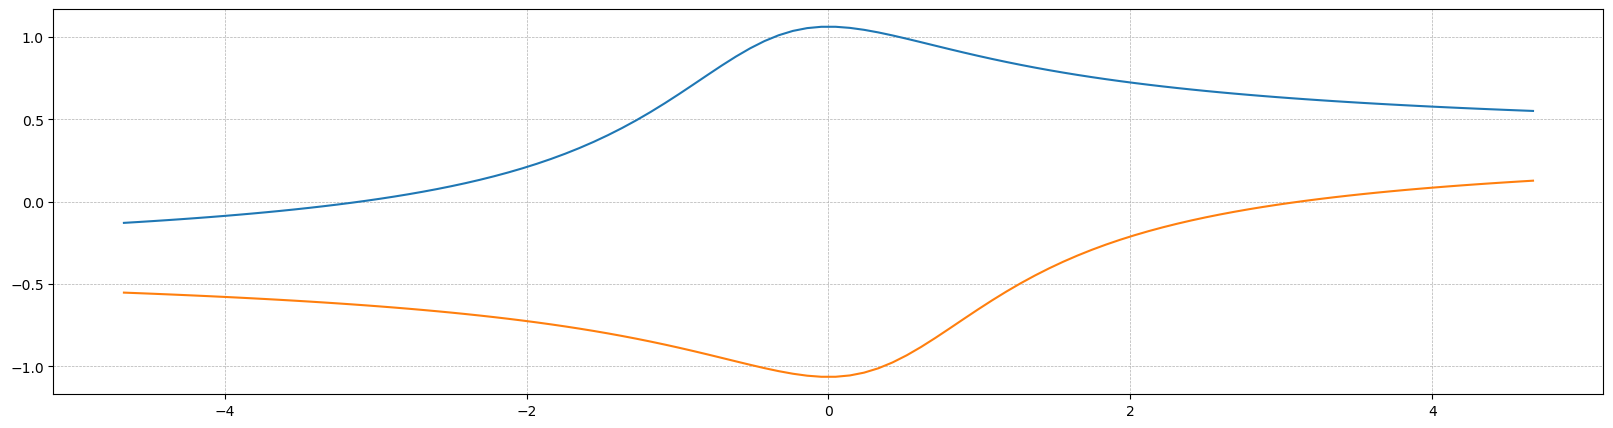

In [23]:
import scipy as sp
import numpy as np
from freecad import part
from freecad import app
from pygears.transformation import numeric_transformation
import matplotlib.pyplot as plt

debug = False
def compute_involute(module=1, teeth=15, height=5, worm_pitch_diameter=10, num_threads=1, alpha=np.deg2rad(20)):
    y = 0.
    xw = worm_pitch_diameter / 2
    
    def r(x, y):
        return (x**2 + y**2)**(0.5)

    def dr_dx(x, y):
        return x / r(x, y)
    
    def z(x, y, t):
        r_xy = r(x, y)
        return (r_xy - xw) * np.tan(alpha) + t

    def dz_dx(x, y, t):
        r_xy = r(x, y)
        return np.tan(alpha) * dr_dx(x,y)

    def distance_pw(x, y, t):
        return np.sqrt((xw - x) ** 2 + z(x, y, t) ** 2)

    def d_distance_pw_dx(x, y, t):
        return (x - xw + z(x,y,t) * dz_dx(x,y,t)) / np.sqrt((x-xw) ** 2 + z(x,y,t) ** 2)

    def min_root(y, t):
        r0 = xw +  module # * (1 + clearence)
        return d_distance_pw_dx(r0, y, t)
        
    def min_head(y, t):
        r1 = xw -  module # * (1 + clearence)
        return d_distance_pw_dx(r1, y, t)
        
    xyz = []        
    r0 = xw -  module # * (1 + clearence)
    r1 = xw +  module # * (1 + clearence)
    t_start_0 = (r0 - xw) * (np.tan(alpha) + 1. / np.tan(alpha))
    t_start_1 = (r1 - xw) * (np.tan(alpha) + 1. / np.tan(alpha))
    print(f"t_start_1: {t_start_0}")
    print(f"t_start_0: {t_start_1}")

    t_i = np.linspace(t_start_0 * 1.5, t_start_1 * 1.5, 100)
    plt.figure(figsize=(20,5))
    plt.plot(t_i, [min_root(y, t) for t in t_i])
    plt.plot(t_i, [min_head(y, t) for t in t_i])
    plt.grid(which='both', linestyle='--', linewidth=0.5)  # Gitterlinien für Major und Minor
    plt.grid(which='minor', linestyle=':', linewidth=0.3)
    t0 = sp.optimize.root(lambda t: min_head(y, t)**2, t_start_1).x[0]
    t1 = sp.optimize.root(lambda t: min_root(y, t)**2, t_start_0).x[0]
    print(f"t0: {t0}, min: {min_head(y, t0)**2}")
    print(f"t1: {t1}, min: {min_root(y, t1)**2}")        
    print(f"t0: {t_start_0}, min: {min_root(y, t_start_0)}")
    print(f"t1: {t_start_1}, min: {min_head(y, t_start_1)}")
    for t in np.linspace(t0, t1, 20):
        x_t = sp.optimize.minimize(lambda x: distance_pw(x, y, t), xw).x[0]
        z_t = z(x_t, y, t)
        point = App.Vector(x_t, y, z_t)
        part.show(part.Point(point).toShape())

compute_involute()